# PHÂN TÍCH VÀ DỰ ĐOÁN GIÁ NÔNG SẢN

# I. Nhóm thực hiện:
  #### - Nguyễn Trung Nghĩa - 21110560
  #### - Trần Minh Dũng - 2111

# II. Giải thích dữ liệu

# III. Thực hiện

## 1. Áp dụng thư viện

In [98]:
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from common import create_spark_session, read_warehouse_pandas

## 2. Khởi tạo Spark Session

In [99]:
spark = create_spark_session("ForecastCropPrice")

## 3. Đọc dữ liệu

### 3.1 Đọc dữ liệu về các loại cây trồng

In [100]:
df_crops = read_warehouse_pandas(spark, f"""
          SELECT distinct(ff.CropCode), Crops
          FROM default.fact_faostat AS ff
          JOIN default.dim_crops AS dc ON ff.CropCode = dc.Crops_Code
          WHERE ProducerPrice_LCU_tonne_LCU_month IS NOT NULL
          """)

### 3.1 Đọc dữ liệu các thông tin cần thiết

In [101]:
df_spark = read_warehouse_pandas(spark, f"""
    SELECT  ff.AreaHarvested_ha_year,
            ff.Production_t_year,
            ff.Yield_kg_ha_year,
            ff.GrossProductionIndexNumber_2014_2016_100_year,
            ff.GrosspercapitaProductionIndexNumber_2014_2016_100_year,
            ff.GrossProductionValueconstant_2014_2016_thousand_1000_Int_year,
            ff.GrossProductionValueconstant_2014_2016_thousandSLC_1000_SLC_year,
            ff.ExportQuantity_t_year,
            ff.ProducerPrice_LCU_tonne_LCU_month,
            fw.Humidity,
            fw.Precip,
            fw.Solarenergy,
            dd.YearMonth,
            ff.CropCode
    FROM default.fact_faostat AS ff
        JOIN (  SELECT  AVG(Humidity) AS Humidity,
                        AVG(Precip) AS Precip,
                        AVG(Solarenergy) AS Solarenergy,
                        DateINT
                FROM default.fact_weather
                GROUP BY DateINT ) AS fw
                ON fw.DateInt = ff.DateINT
        JOIN default.dim_date  AS dd ON dd.DateINT = ff.DateINT
    WHERE ProducerPrice_LCU_tonne_LCU_month IS NOT NULL
    ORDER BY dd.YearMonth
""")

## 4. Tiền xử lý dữ liệu

### 4.1. Lọc dữ liệu bị thiếu trong tập dữ liệu

In [102]:
df_pandas = df_spark.dropna()

missing_values = df_pandas.isnull().sum()
print(missing_values)

AreaHarvested_ha_year                                               0
Production_t_year                                                   0
Yield_kg_ha_year                                                    0
GrossProductionIndexNumber_2014_2016_100_year                       0
GrosspercapitaProductionIndexNumber_2014_2016_100_year              0
GrossProductionValueconstant_2014_2016_thousand_1000_Int_year       0
GrossProductionValueconstant_2014_2016_thousandSLC_1000_SLC_year    0
ExportQuantity_t_year                                               0
ProducerPrice_LCU_tonne_LCU_month                                   0
Humidity                                                            0
Precip                                                              0
Solarenergy                                                         0
YearMonth                                                           0
CropCode                                                            0
dtype: int64


### 4.2. Lọc thuộc tính dữ liệu có độ tương quan cao

<Axes: >

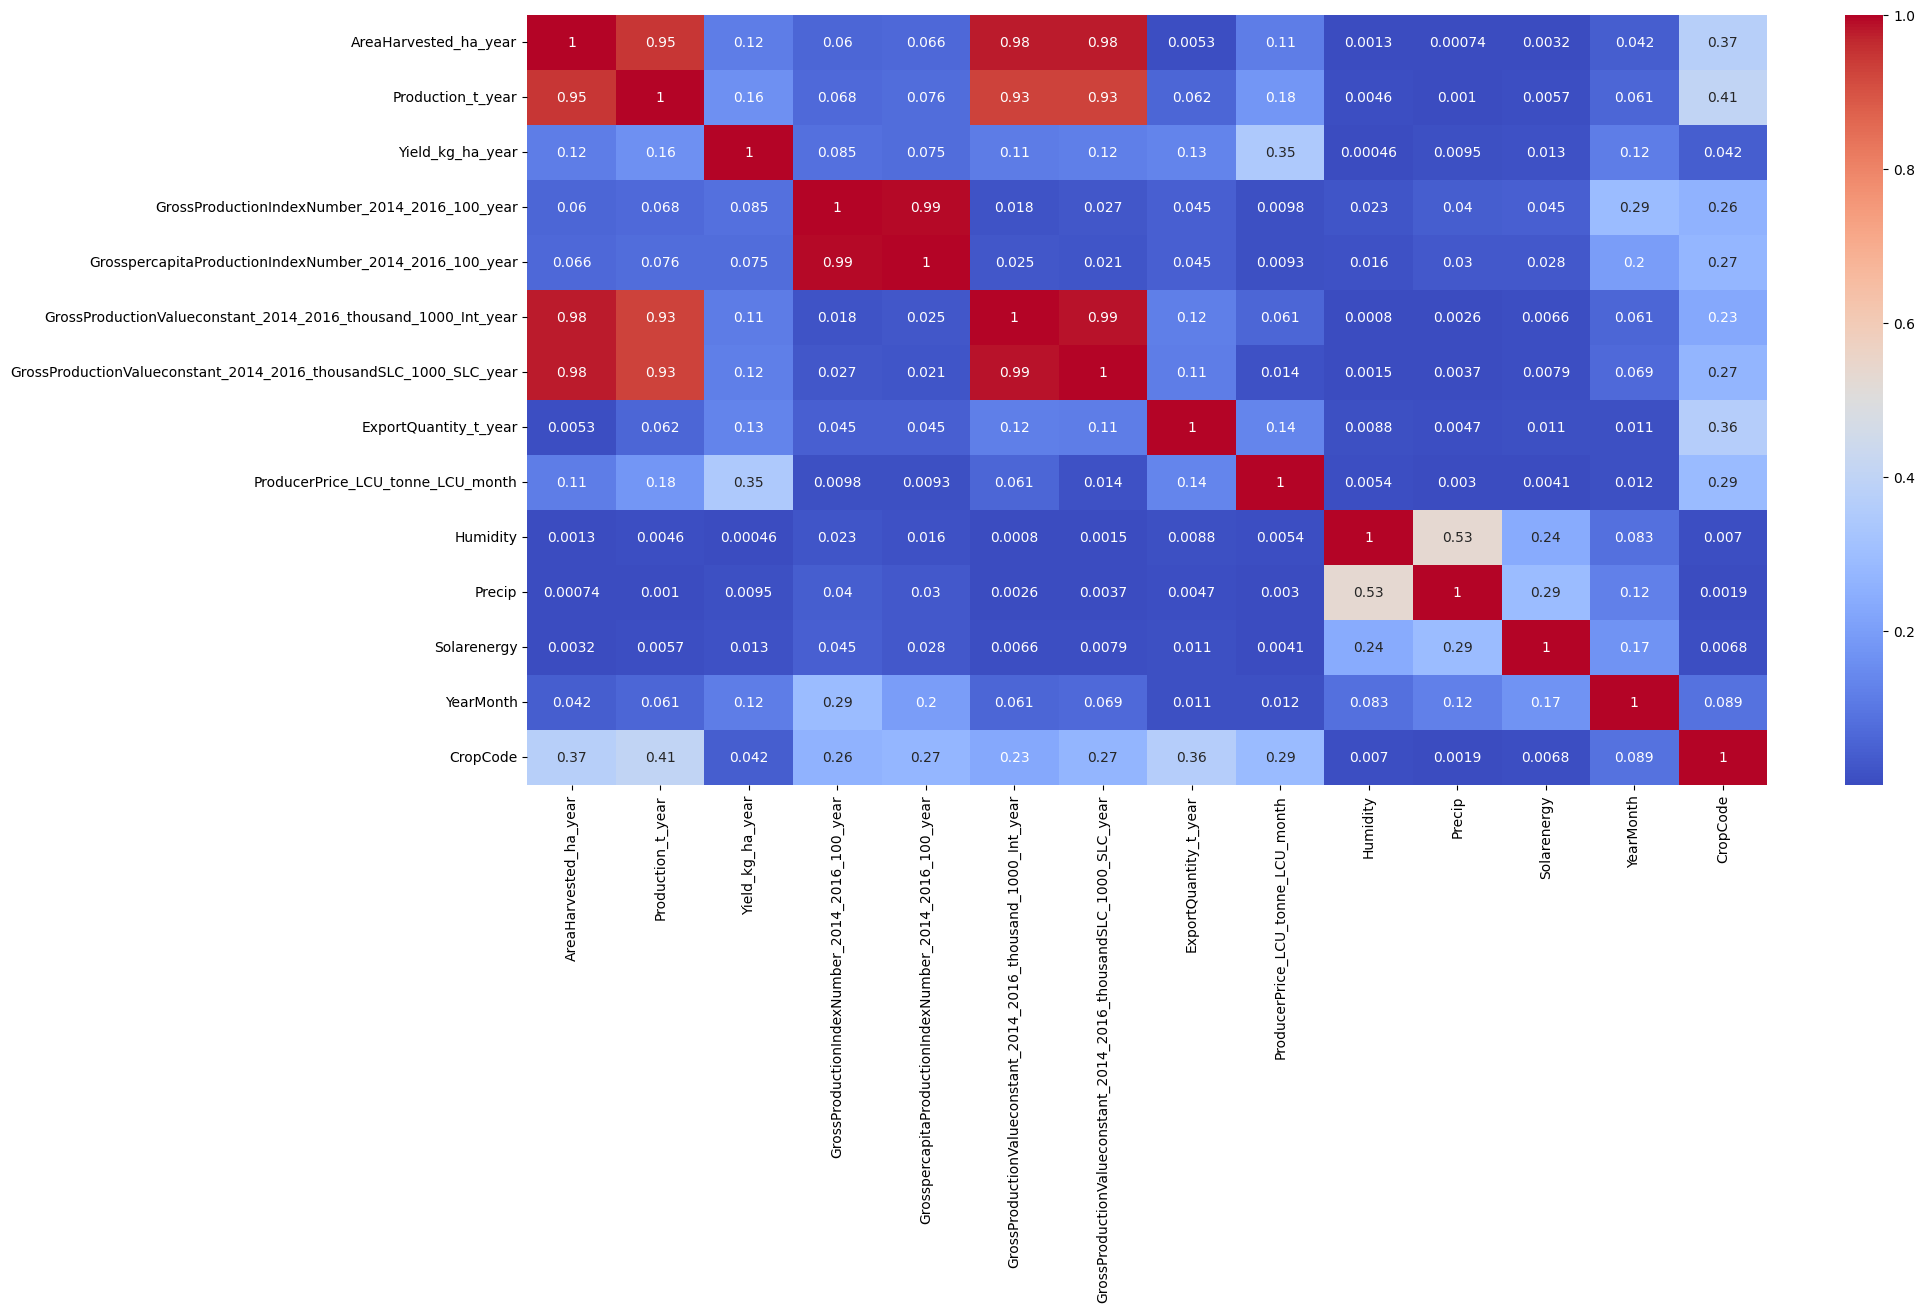

In [103]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_pandas.corr().abs(), cmap="coolwarm",  annot=True)

In [104]:
df_pandas = df_pandas.drop(['GrossProductionValueconstant_2014_2016_thousand_1000_Int_year',
                            'GrosspercapitaProductionIndexNumber_2014_2016_100_year',
                            'GrossProductionValueconstant_2014_2016_thousandSLC_1000_SLC_year',
                            'AreaHarvested_ha_year',
                            'Production_t_year',
                            'Yield_kg_ha_year',
                            ], axis=1)

<Axes: >

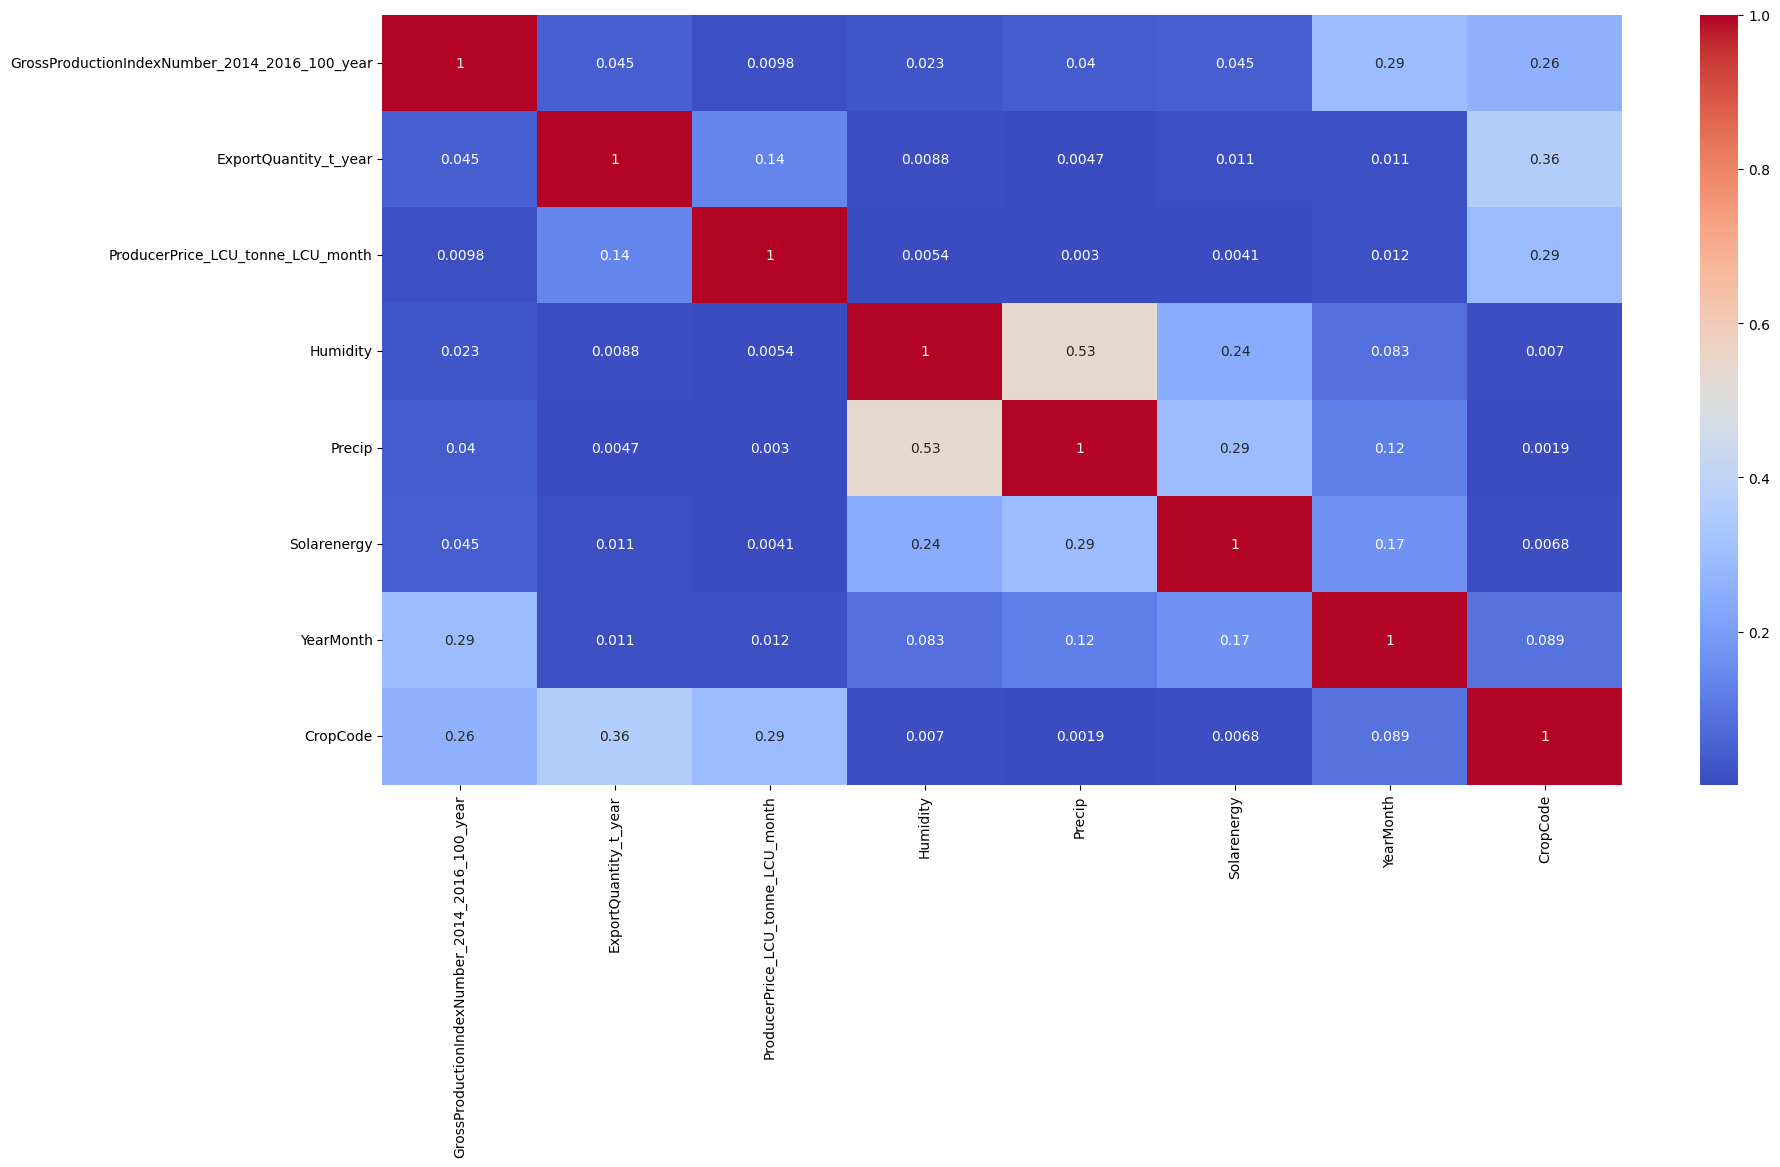

In [105]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_pandas.corr().abs(), cmap="coolwarm",  annot=True)

### 4.3. Phân tách dữ liệu thành tập train và tập test

In [106]:
df_pandas = pd.get_dummies(df_pandas, columns=['CropCode'])
df_pandas['YearMonth2'] = df_pandas['YearMonth']

In [107]:
df_test = df_pandas[(df_pandas['YearMonth2'] >= 202000)]
df_train = df_pandas[(df_pandas['YearMonth2'] < 202000)]

X_train = df_train.drop(
    ['ProducerPrice_LCU_tonne_LCU_month', 'YearMonth2'], axis=1)
y_train = df_train['ProducerPrice_LCU_tonne_LCU_month']

X_test = df_test.drop(
    ['ProducerPrice_LCU_tonne_LCU_month', 'YearMonth2'], axis=1)
y_test = df_test['ProducerPrice_LCU_tonne_LCU_month']

X_test = pd.DataFrame(preprocessing.normalize(
    X_test, norm='l2'), columns=X_test.columns)
X_train = pd.DataFrame(preprocessing.normalize(
    X_train, norm='l2'), columns=X_train.columns)

## 5. Áp dụng mô hình 

### 5.1. Mô Hình DecisionTreeRegressor

In [139]:
DT_model = DecisionTreeRegressor(random_state=42)

DT_model.fit(X_train, y_train)

DT_y_pred = DT_model.predict(X_test)

In [140]:
mse = mean_squared_error(y_test, DT_y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, DT_y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 44587771263131.35
Root Mean Squared Error: 6677407.525614365
R-squared: 0.8335282481716529


### 5.2. Mô Hình RandomForestRegressor

In [143]:
RF_model = RandomForestRegressor(random_state=42)
RF_model.fit(X_train, y_train)

RF_y_pred = RF_model.predict(X_test)

In [144]:
mse = mean_squared_error(y_test, RF_y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, RF_y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 39444947345430.85
Root Mean Squared Error: 6280521.2638308015
R-squared: 0.8527293627972733


In [145]:
df_crops

,CropCode,Crops
0,125,"Cassava, fresh"
1,571,"Mangoes, guavas and mangosteens"
2,689,"Chillies and peppers, dry (Capsicum spp., Pime..."
3,176,"Beans, dry"
4,486,Bananas
5,507,Pomelos and grapefruits
6,403,"Onions and shallots, dry (excluding dehydrated)"
7,249,"Coconuts, in shell"
8,490,Oranges
9,393,Cauliflowers and broccoli


## 6. Kết quả dự đoán

In [146]:
def plot_act_pre(crop_code, pred_model='RF', both=False):
    df_test_temp = df_test.copy()
    df_test_temp['DT_pred'] = DT_y_pred
    df_test_temp['RF_pred'] = RF_y_pred
    crop_name = df_crops[df_crops['CropCode'] == crop_code]['Crops'].values[0]

    df_true_crop = df_pandas[(df_pandas[f'CropCode_{crop_code}'] > 0)].copy()
    df_test_crop = df_test_temp[(
        df_test_temp[f'CropCode_{crop_code}'] > 0)].copy()
    df_true_crop['Datetime'] = pd.to_datetime(
        df_true_crop['YearMonth2'], format='%Y%m')
    df_test_crop['Datetime'] = pd.to_datetime(
        df_test_crop['YearMonth2'], format='%Y%m')
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df_true_crop['Datetime'], df_true_crop['ProducerPrice_LCU_tonne_LCU_month'],
            '-', label='Train_Prices', color='green', linewidth=1)
    ax.plot(df_test_crop['Datetime'], df_test_crop['ProducerPrice_LCU_tonne_LCU_month'],
            '-', label='True_Prices', color='green', linewidth=1)

    if both:
        ax.plot(df_test_crop['Datetime'], df_test_crop['DT_pred'],
                '-', label='Pred_Prices_DecisionTree', color='blue', linewidth=1)
        ax.plot(df_test_crop['Datetime'], df_test_crop['RF_pred'],
                '-', label='Pred_Prices_RandomForest', color='red', linewidth=1)
    else:
        ax.plot(df_test_crop['Datetime'], df_test_crop[f'{pred_model}_pred'],
                '-', label=f"Pred_Prices_{'RandomForest' if pred_model == 'RF' else 'DecisionTree'}", color='blue', linewidth=1)

    ax.set_xlabel('Date', fontsize=15)
    ax.set_ylabel('Price of Crops', fontsize=15)
    ax.legend(loc='upper left', fontsize=16)
    ax.set_title(f'Price of {crop_name} ', fontsize=20)
    plt.tight_layout()
    plt.show()

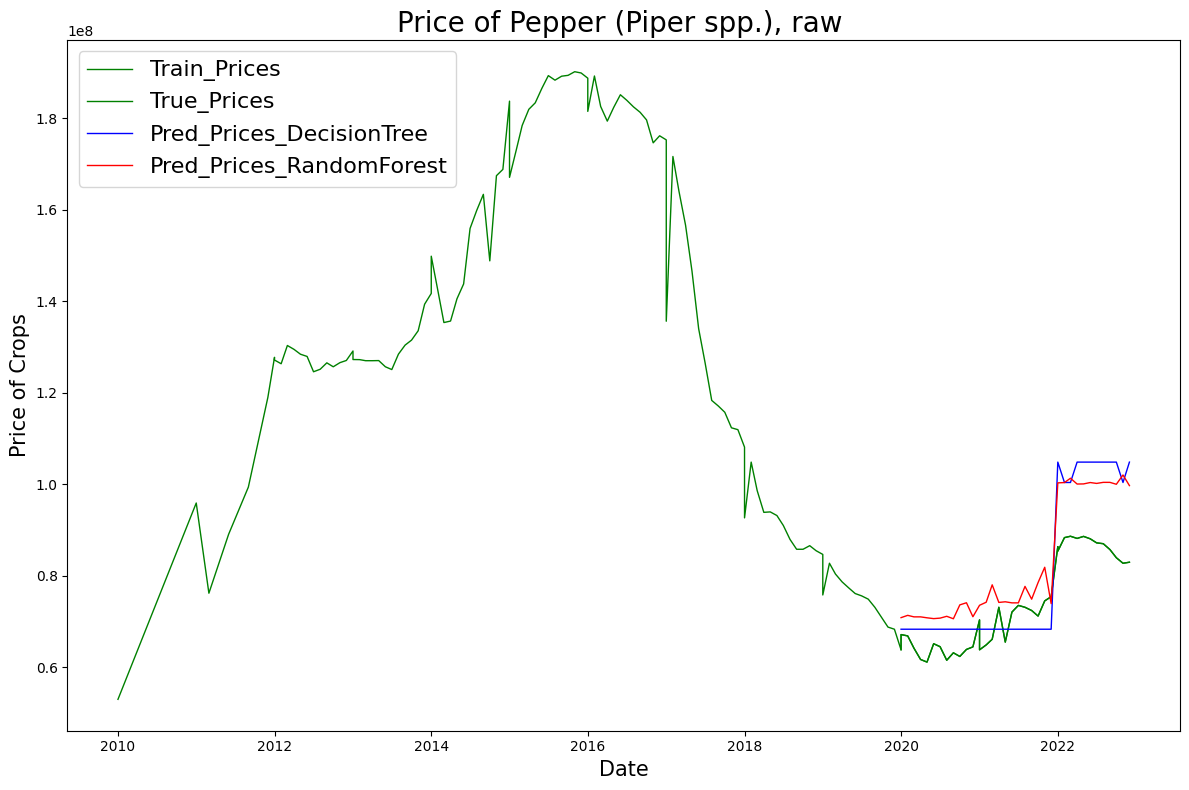

In [135]:
plot_act_pre(687, both=True)

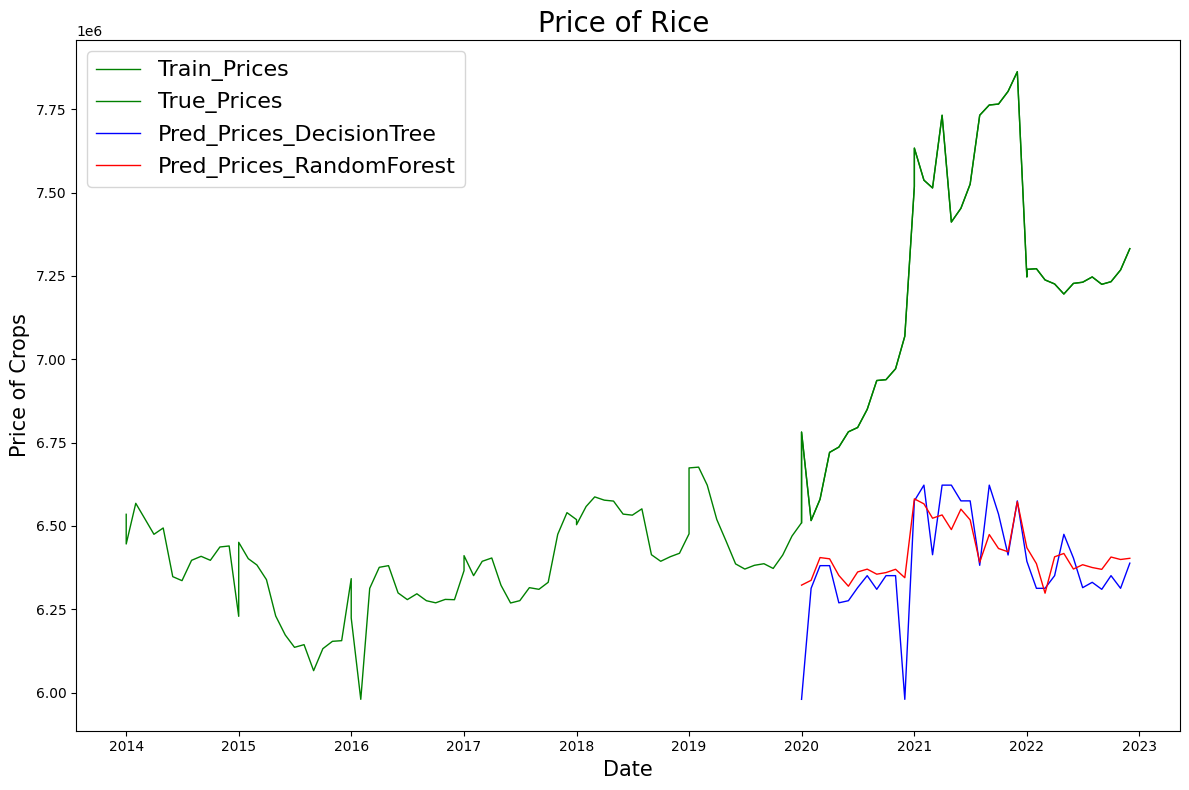

In [147]:
plot_act_pre(27, both=True)

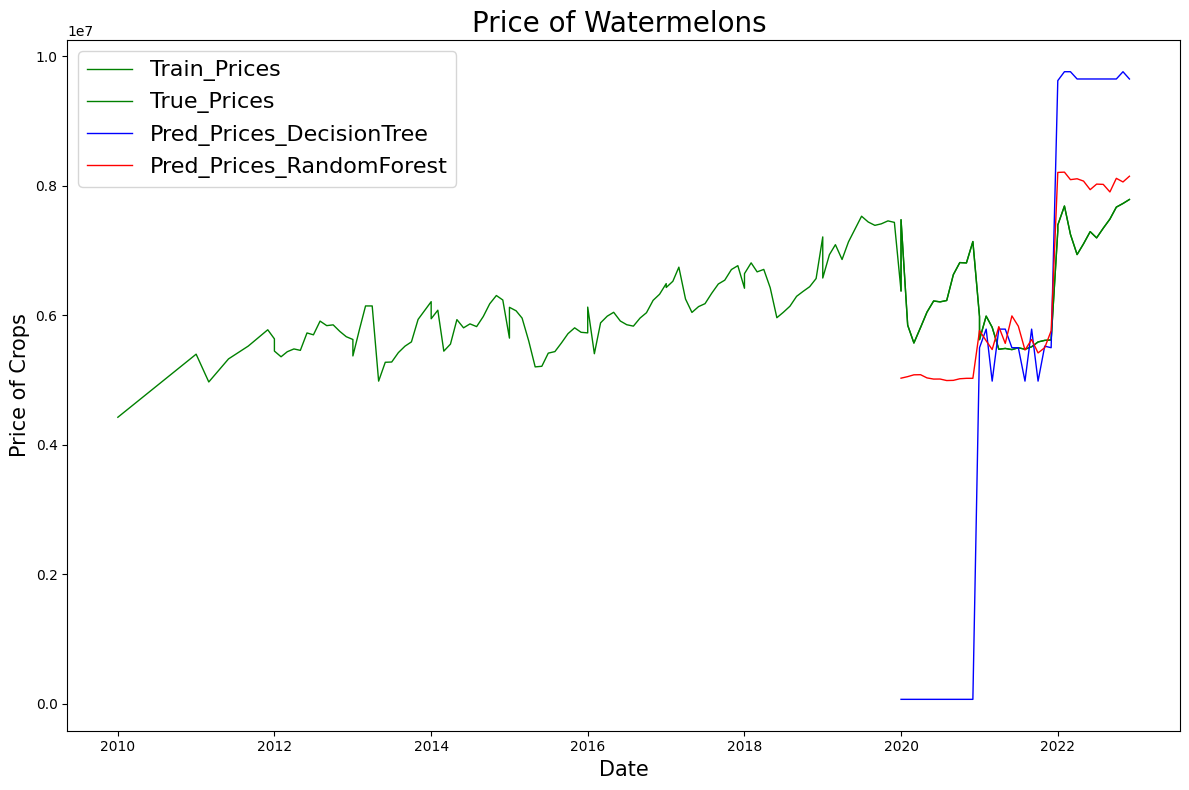

In [148]:
plot_act_pre(567, both=True)

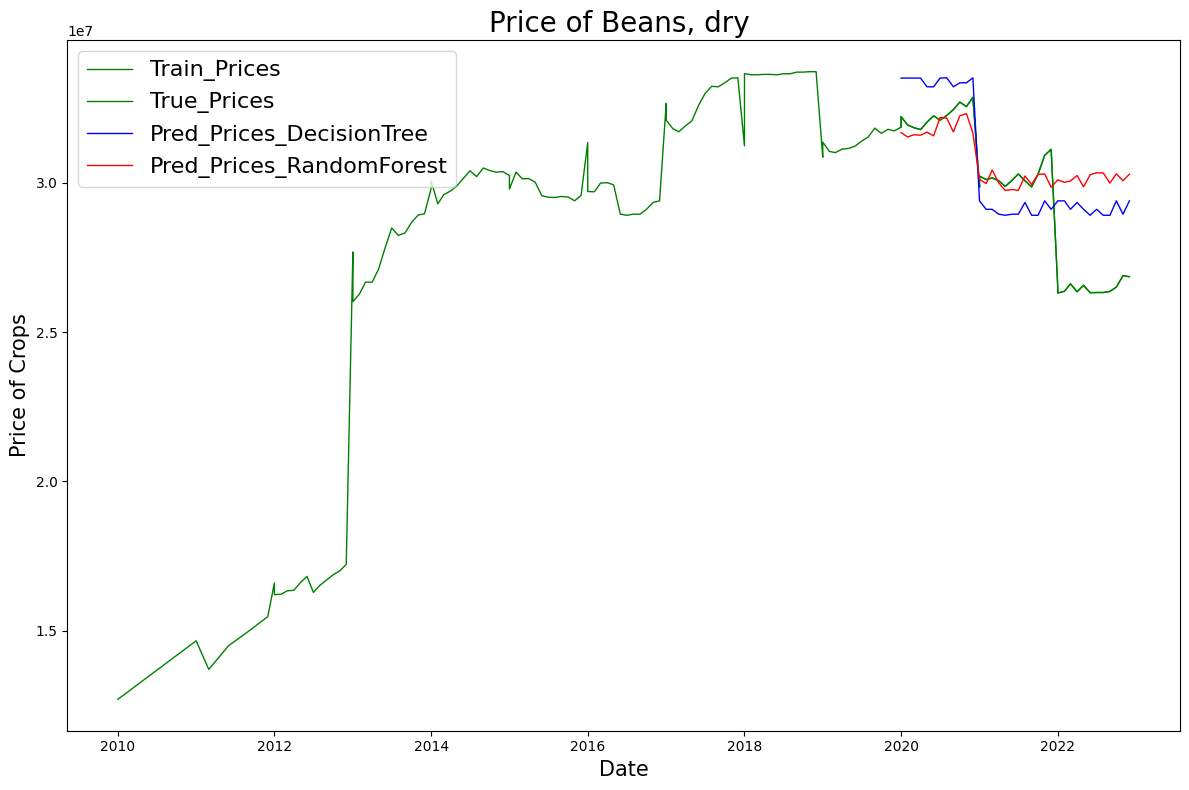

In [149]:
plot_act_pre(176, both=True)

## 7. Dừng Spark

In [58]:
spark.stop()